In [1]:
import pandas as pd
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['OMP_NUM_THREADS'] = '4'
## print list of files in kaggle 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        continue


In [3]:
# Load the dataset
df = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')

In [4]:
df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df[class_names].apply(lambda x: x.value_counts())

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,144277,157976,151122,159093,151694,158166
1,15294,1595,8449,478,7877,1405


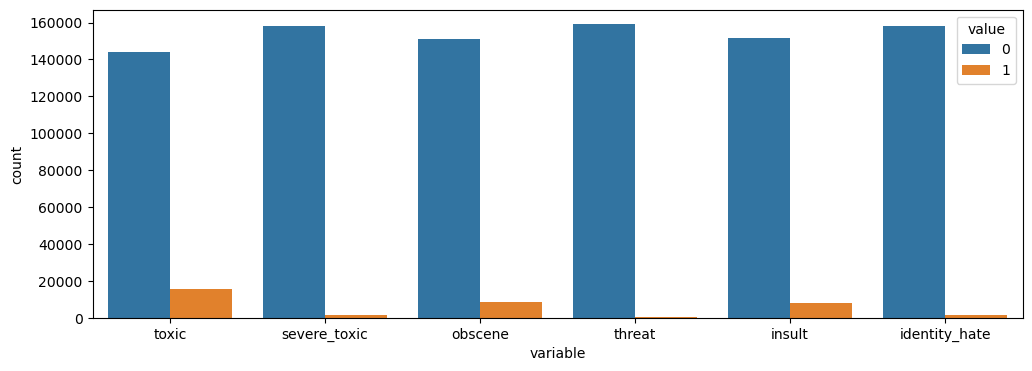

In [6]:
plt.figure(figsize=(12,4))
sns.countplot(x="variable", hue="value", data=pd.melt(df[class_names]))

plt.show()

In [7]:
df_toxic = df[df['toxic'] == 1]
df_non_toxic = df[df['toxic'] == 0].sample(15294)

print(df_toxic.shape,df_non_toxic.shape)

(15294, 8) (15294, 8)


In [8]:
df_new = pd.concat([df_toxic,df_non_toxic])
df_new.shape

(30588, 8)

In [9]:
df_new = df_new.drop(['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis = 1)

In [10]:
df_new.head(5)

,id,comment_text,toxic
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1


In [11]:
df_new['toxic'].value_counts()

1    15294
0    15294
Name: toxic, dtype: int64

In [12]:
! python -m spacy download en_core_web_lg

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [13]:
import spacy 
nlp = spacy.load('en_core_web_lg')

In [14]:
def preprocess(text):
  doc = nlp(text)
  filtered = []
  for token in doc:
    if token.is_stop or token.is_punct:
      continue
    else :
      filtered.append(token.lemma_.lower())
  return ' '.join(filtered)

In [15]:
df_new['comment_text'] = df_new['comment_text'].apply(preprocess)

In [16]:
df_new['comment_text'] = df_new['comment_text'].apply(lambda x: x.replace('\n', ' '))

In [17]:
df_new['vec'] = df_new['comment_text'].apply(lambda x : nlp(x).vector)

(15294, 4)


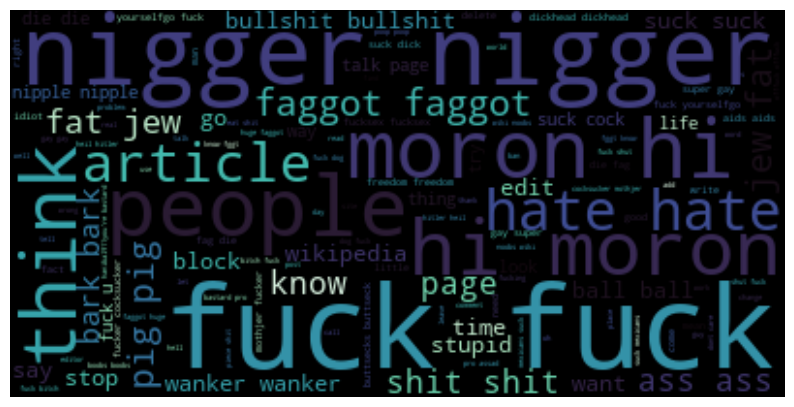

In [18]:
hate_df = df_new[(df_new['toxic'] != 0)]
print(hate_df.shape)
text = ' '.join(hate_df['comment_text'])

palette = sns.color_palette("mako", as_cmap=True)
wordcloud = WordCloud(stopwords=set(STOPWORDS),background_color='black', colormap=palette)
wordcloud.generate(text)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [19]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric])

In [20]:
X = df_new.iloc[:,1]
print(X.shape)
Y = np.array(df_new.iloc[:,2])
print(Y.shape)

(30588,)
(30588,)


In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [22]:
type(y_test)

numpy.ndarray

In [23]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([12269, 12201]))

In [24]:
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences

In [25]:
max_words = 8000
max_len = 200
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

# GRU

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense, Embedding, Input


In [27]:
model = tf.keras.Sequential([
    Input(shape=[max_len]),
    Embedding(max_words, 50, input_length=max_len),
    tf.keras.layers.GRU(256, activation='tanh'),
    Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])



In [28]:
model.compile(loss='BinaryCrossentropy',
             optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
             metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [29]:
history = model.fit(sequences_matrix, y_train, epochs=10)

Epoch 1/10
765/765 [==============================] - 67s 80ms/step - loss: 0.3918 - accuracy: 0.8350 - recall: 0.8292 - precision: 0.8381
Epoch 2/10
765/765 [==============================] - 20s 26ms/step - loss: 0.2229 - accuracy: 0.9135 - recall: 0.9128 - precision: 0.9136
Epoch 3/10
765/765 [==============================] - 16s 21ms/step - loss: 0.1927 - accuracy: 0.9247 - recall: 0.9265 - precision: 0.9229
Epoch 4/10
765/765 [==============================] - 14s 18ms/step - loss: 0.1739 - accuracy: 0.9347 - recall: 0.9362 - precision: 0.9330
Epoch 5/10
765/765 [==============================] - 12s 15ms/step - loss: 0.1591 - accuracy: 0.9412 - recall: 0.9431 - precision: 0.9391
Epoch 6/10
765/765 [==============================] - 12s 16ms/step - loss: 0.1430 - accuracy: 0.9483 - recall: 0.9514 - precision: 0.9454
Epoch 7/10
765/765 [==============================] - 12s 15ms/step - loss: 0.1310 - accuracy: 0.9542 - recall: 0.9539 - precision: 0.9543
Epoch 8/10
765/765 [=======

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 50)           400000    
                                                                 
 gru (GRU)                   (None, 256)               236544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

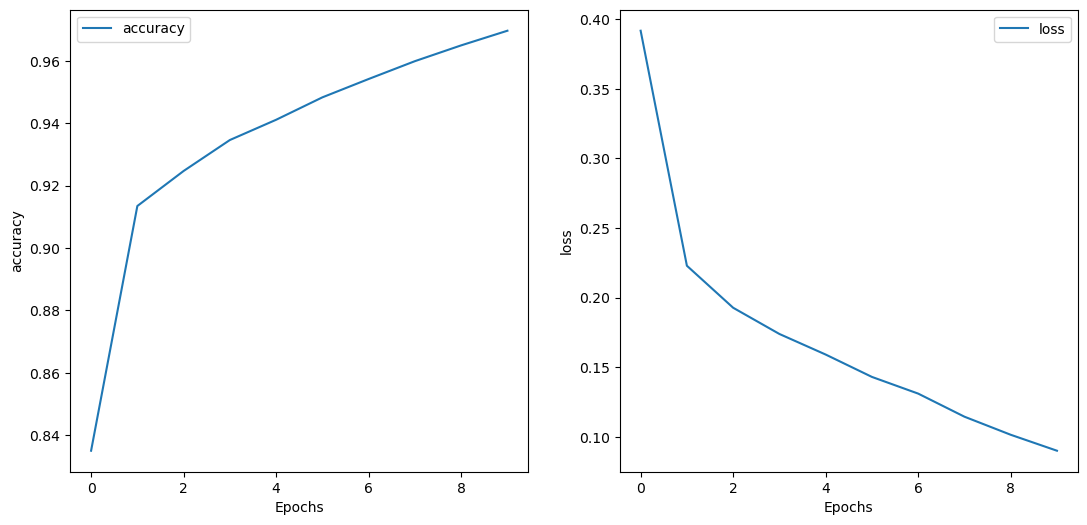

In [31]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='gru.png', show_shapes=True)

plt.figure(figsize=(13, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
